In [1]:
# importing the required libraries
import numpy as numpy
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#image data generator

train_datagen = ImageDataGenerator(rescale=1./255., preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory("dataset/train",
                                                    target_size=(150,150),
                                                    color_mode="rgb",
                                                    batch_size=16,
                                                    class_mode="categorical")

Found 480 images belonging to 2 classes.


In [4]:
valid_datagen = ImageDataGenerator(rescale=1./255., preprocessing_function=preprocess_input)

valid_generator = valid_datagen.flow_from_directory("dataset/valid",
                                                    target_size=(150,150),
                                                    color_mode="rgb",
                                                    batch_size=16,
                                                    class_mode="categorical")

Found 480 images belonging to 2 classes.


## Transfer learning

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [6]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(150,150,3))

In [7]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
model_tl = Sequential()

model_tl.add(base_model)
model_tl.add(Flatten())
model_tl.add(Dense(2, activation="softmax"))

In [9]:
# Don't train first layer (vgg19)
model_tl.layers[0].trainable = False

In [10]:
model_tl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
# compiling
model_tl.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
fit_history = model_tl.fit(train_generator, validation_data=valid_generator, epochs=5)

Epoch 1/5
30/30 [==============================] - 133s 4s/step - loss: 0.3185 - accuracy: 0.8562 - val_loss: 0.0818 - val_accuracy: 0.9708
Epoch 2/5
30/30 [==============================] - 134s 4s/step - loss: 0.0371 - accuracy: 0.9937 - val_loss: 0.0680 - val_accuracy: 0.9750
Epoch 3/5
30/30 [==============================] - 137s 5s/step - loss: 0.0207 - accuracy: 0.9979 - val_loss: 0.0681 - val_accuracy: 0.9792
Epoch 4/5
30/30 [==============================] - 137s 5s/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.0623 - val_accuracy: 0.9771
Epoch 5/5
30/30 [==============================] - 137s 5s/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0691 - val_accuracy: 0.9792


## Test the model

In [25]:
test_datagen = ImageDataGenerator(rescale=1./255., preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory("dataset/test",
                                                    target_size=(150,150),
                                                    color_mode="rgb",
                                                    batch_size=1,
                                                    class_mode="categorical",
                                                    shuffle=False)

Found 37 images belonging to 2 classes.


### Visualize predictions

In [26]:
test_generator.reset()

pred = model_tl.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = numpy.argmax(pred, axis = 1)

37/37 [==============================] - 8s 206ms/step


In [23]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

In [27]:
read = lambda image_name: numpy.asarray(load_img(image_name, target_size=(150, 150)))

def plot_image(base_path, images, image_count, labels, image_width=18, image_height=12):
    fig=plt.figure(figsize=(image_width, image_height))
    
    columns = 10
    rows = image_count // columns

    for i in range(1, columns*rows + 1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(labels[i])
        img = read(os.path.join(base_path, images[i]))
        plt.imshow(img, interpolation='nearest')

In [28]:
labels = ["Pizza" if predicted_class_indices[i] else "Hot Dog" for i in range(len(predicted_class_indices))]

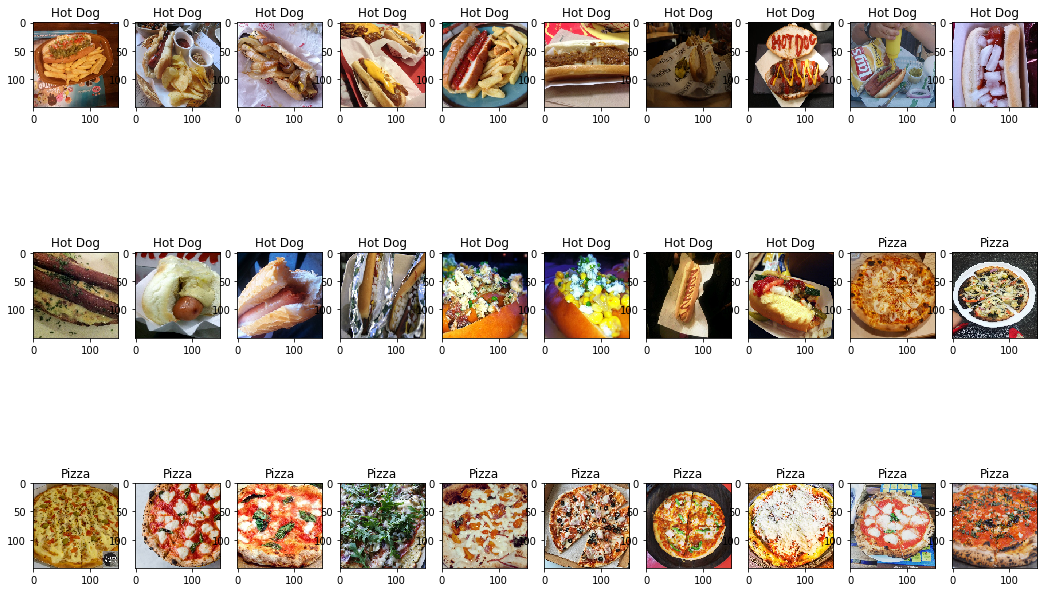

In [29]:
plot_image("dataset/test", test_generator.filenames, 37, labels)